In [4]:
pip install nibabel matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import zipfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Step 1: Load Data**

In [6]:
# Define paths
data_path = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
zip_file = os.path.join(data_path, 'HNTSMRG24_train.zip')

# Path to save extracted files
extracted_path = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'

# Create extraction directory if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # List all files in the ZIP archive
    all_files = zip_ref.namelist()
    
    # Filter out only the files that are inside the 'preRT/' directories
    preRT_files = [f for f in all_files if '/preRT/' in f]
    
    # Extract only the 'preRT/' files
    for file in preRT_files:
        zip_ref.extract(member=file, path=extracted_path)

print("Extraction complete.")

Extraction complete.


In [7]:
# Path to the training data
train_dir = os.path.join(extracted_path, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(train_dir)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


# **Step 2: Exploratory Data Analysis**

In [8]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders[:5]: # TODO

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))


In [9]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

print("Image Dimensions:")
print(f"Minimum dimensions: {min_dims}")
print(f"Maximum dimensions: {max_dims}")
print(f"Mean dimensions: {mean_dims.round(2)}")

Image Dimensions:
Minimum dimensions: [512 512  70]
Maximum dimensions: [512 512  77]
Mean dimensions: [512.  512.   72.4]


In [10]:
# Convert voxel sizes to a NumPy array
voxel_sizes_array = np.array(voxel_sizes)

# Calculate min, max, and mean voxel sizes
min_voxels = voxel_sizes_array.min(axis=0)
max_voxels = voxel_sizes_array.max(axis=0)
mean_voxels = voxel_sizes_array.mean(axis=0)

print("\nVoxel Sizes:")
print(f"Minimum voxel sizes: {min_voxels.round(3)}")
print(f"Maximum voxel sizes: {max_voxels.round(3)}")
print(f"Mean voxel sizes: {mean_voxels.round(3)}")



Voxel Sizes:
Minimum voxel sizes: [0.5 0.5 2. ]
Maximum voxel sizes: [0.5 0.5 2. ]
Mean voxel sizes: [0.5 0.5 2. ]


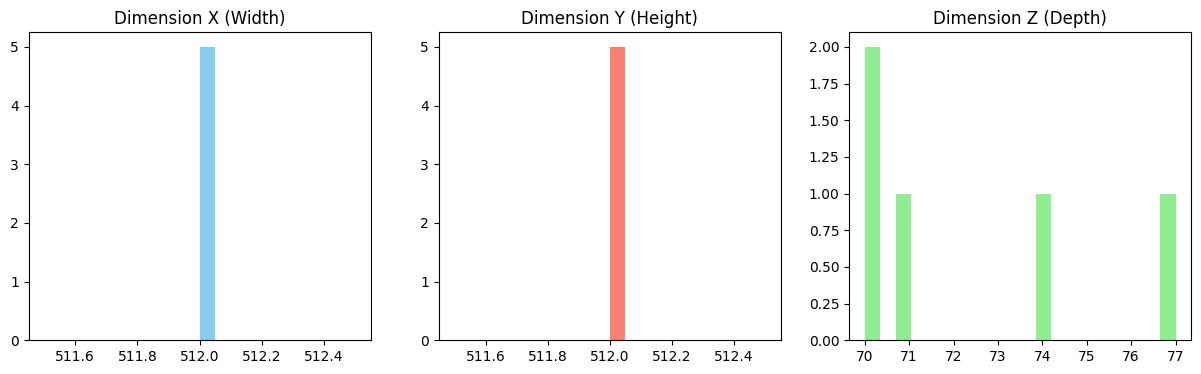

In [11]:
# Plot histograms of dimensions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(dimensions_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Dimension X (Width)')
axes[1].hist(dimensions_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Dimension Y (Height)')
axes[2].hist(dimensions_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Dimension Z (Depth)')
plt.show()

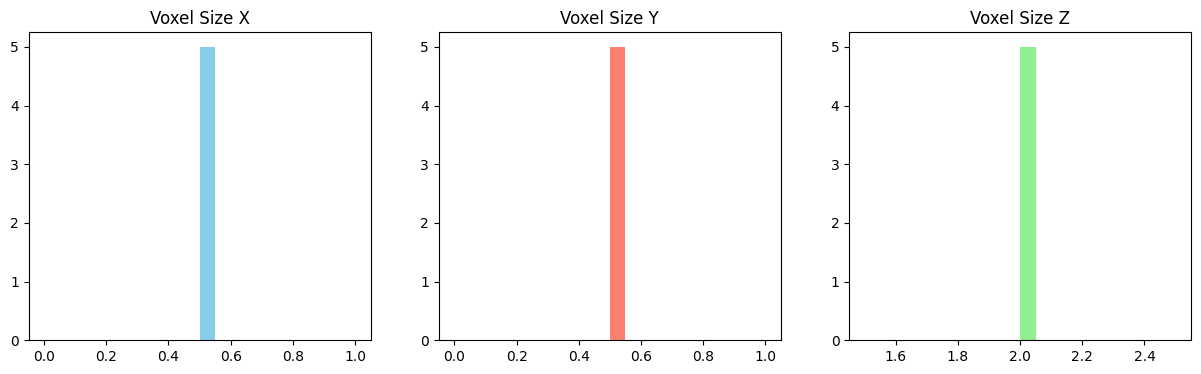

In [12]:
# Plot histograms of voxel sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(voxel_sizes_array[:, 0], bins=20, color='skyblue')
axes[0].set_title('Voxel Size X')
axes[1].hist(voxel_sizes_array[:, 1], bins=20, color='salmon')
axes[1].set_title('Voxel Size Y')
axes[2].hist(voxel_sizes_array[:, 2], bins=20, color='lightgreen')
axes[2].set_title('Voxel Size Z')
plt.show()

In [13]:
# Create a DataFrame from intensity statistics
intensities_df = pd.DataFrame(intensities)

# Display summary statistics
print(intensities_df.describe())

            mean        std  min         max
count   5.000000   5.000000  5.0    5.000000
mean   35.715190  54.064876  0.0  426.200000
std     8.599927  12.888931  0.0   33.566352
min    22.462490  32.638056  0.0  379.000000
25%    32.770304  51.593564  0.0  417.000000
50%    37.457270  60.540675  0.0  427.000000
75%    41.526442  61.106106  0.0  436.000000
max    44.359442  64.445978  0.0  472.000000


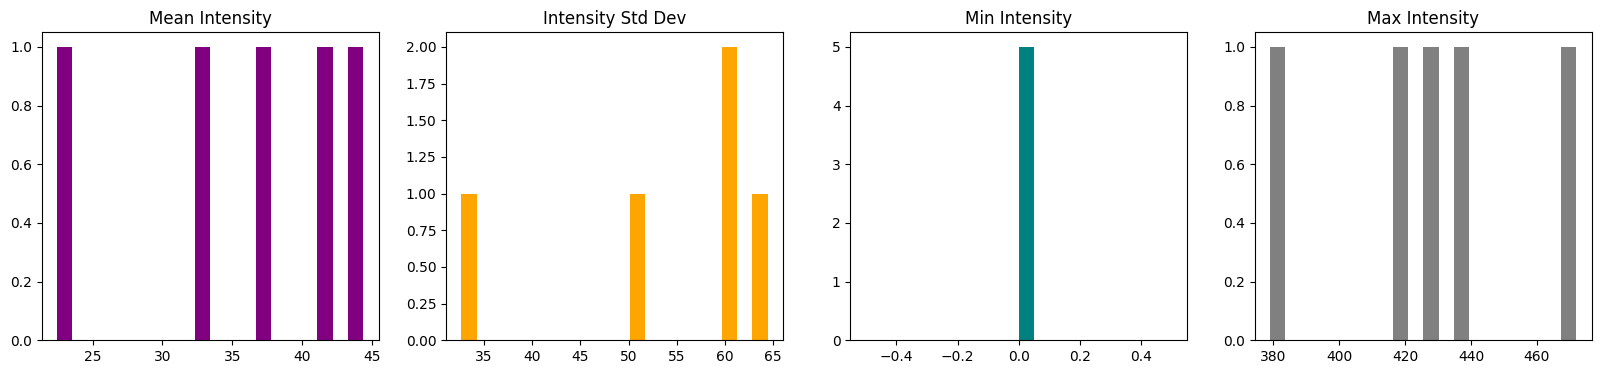

In [14]:
# Plot histograms of intensity statistics
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(intensities_df['mean'], bins=20, color='purple')
axes[0].set_title('Mean Intensity')
axes[1].hist(intensities_df['std'], bins=20, color='orange')
axes[1].set_title('Intensity Std Dev')
axes[2].hist(intensities_df['min'], bins=20, color='teal')
axes[2].set_title('Min Intensity')
axes[3].hist(intensities_df['max'], bins=20, color='gray')
axes[3].set_title('Max Intensity')
plt.show()

In [15]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

print("Class Distribution in Masks (% of total voxels):")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.4f}%")

Class Distribution in Masks (% of total voxels):
Class 0: 99.7576%
Class 1: 0.1009%
Class 2: 0.1415%


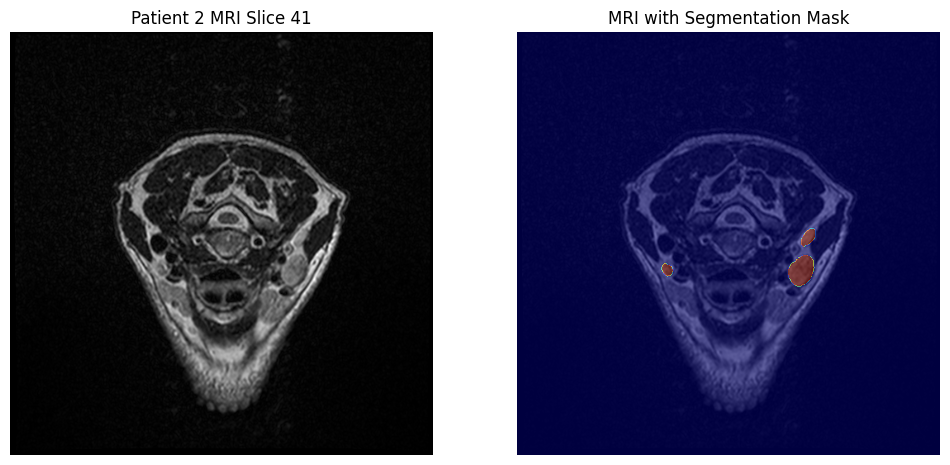

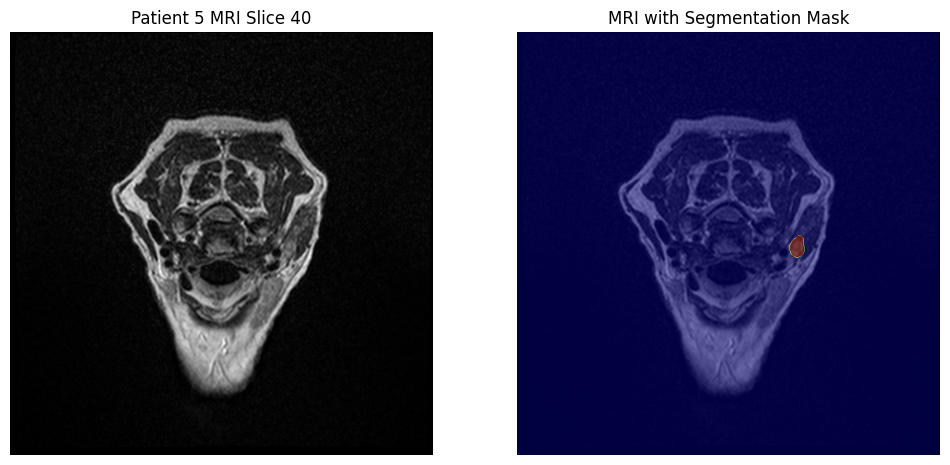

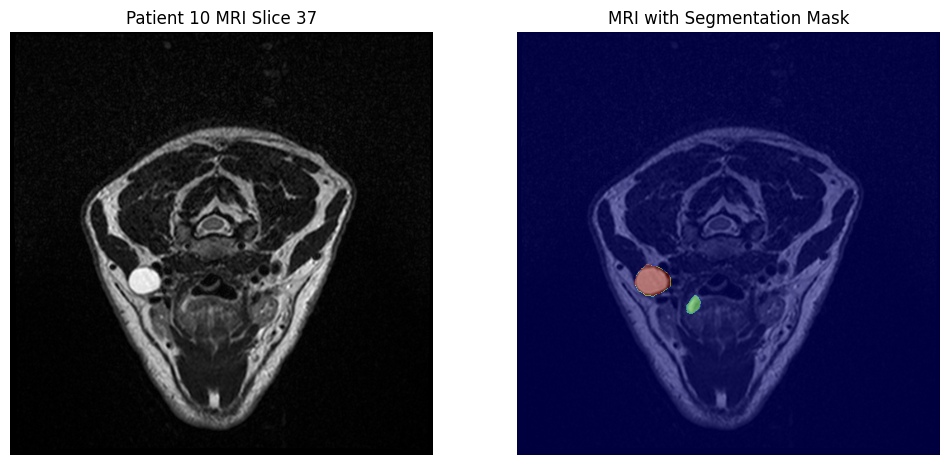

In [16]:
def plot_sample(patient_id, slice_index=None):
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # If no slice index is provided, use the middle slice
    if slice_index is None:
        slice_index = mri_data.shape[2] // 2
    
    mri_slice = mri_data[:, :, slice_index]
    mask_slice = mask_data[:, :, slice_index]
    
    # Plot MRI and Mask
    plt.figure(figsize=(12, 6))
    
    # MRI Image
    plt.subplot(1, 2, 1)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.title(f'Patient {patient_id} MRI Slice {slice_index}')
    plt.axis('off')
    
    # Mask Overlay
    plt.subplot(1, 2, 2)
    plt.imshow(mri_slice.T, cmap='gray', origin='lower')
    plt.imshow(mask_slice.T, cmap='jet', alpha=0.5, origin='lower')
    plt.title('MRI with Segmentation Mask')
    plt.axis('off')
    
    plt.show()

# Plot samples from a few patients
sample_patients = ['2', '5', '10']
for pid in sample_patients:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

In [1]:
import os
import torch
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    ScaleIntensityRanged, CropForegroundd, Resized, EnsureTyped,
    RandFlipd, RandRotate90d
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

# Define paths
train_dir = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data/HNTSMRG24_train'

# Get patient IDs
patient_ids = [pid for pid in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, pid))]

# Create data dictionaries
data_dicts = [
    {
        "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
        "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
    }
    for pid in patient_ids
]

# Split data into training and validation sets
train_files = data_dicts[:130]  # First 130 patients for training
val_files = data_dicts[130:]    # Remaining for validation

# Define transforms
desired_spacing = (1.0, 1.0, 1.0)
desired_shape = (256, 256, 256)

preprocess_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=desired_spacing, mode=("bilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=desired_shape, mode=("trilinear", "nearest")),
    EnsureTyped(keys=["image", "label"]),
])

train_transforms = Compose([
    preprocess_transforms,
    RandFlipd(keys=["image", "label"], spatial_axis=[0, 1, 2], prob=0.5),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
])

# Create datasets and data loaders
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_files, transform=preprocess_transforms, cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

# Define the model, loss function, optimizer, and metric
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # Number of classes
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training loop
max_epochs = 1
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(epoch_loss)
    epoch_loss /= len(train_loader)
    print(f"Training loss: {epoch_loss:.4f}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_dice = 0.0
        for val_data in val_loader:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device)
            val_outputs = model(val_inputs)
            val_outputs = torch.softmax(val_outputs, dim=1)
            val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)
            dice = dice_metric(y_pred=val_outputs, y=val_labels)
            val_dice += dice.item()
        val_dice /= len(val_loader)
        print(f"Validation Dice Score: {val_dice:.4f}")


/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset:   5%|▌         | 1/20 [00:09<02:56,  9.29s/it]

: 

: 

# **Step 4: Build Model**

In [ ]:
# TODO

# **Step 5: Train Model**

In [ ]:
# TODO

----------
epoch 1/5


> collate dict key "image" out of 4 keys
>> collate/stack a list of tensors
>> E: stack expects each tensor to be equal size, but got [1, 96, 96, 64] at entry 0 and [1, 96, 96, 60] at entry 4, shape [torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 64]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60]), torch.Size([1, 96, 96, 60])] in collate([metatensor([[[[0.5973, 0.4661, 0.4163,  ..., 0.4480, 0.8100, 0.8009],
          [0.3213, 0.4842, 0.5158,  ..., 0.6923, 0.8235, 0.5928],
          [0.5882, 0.5430, 0.5385,  ..., 0.8054, 0.6018, 0.4525],
          ...,
          [0.3439, 0.3077, 0.3032,  ..., 0.3032, 0.2760, 0.2805],
          [0.2805, 0.3032, 0.2805,  ..., 0.2851, 0.2670, 0.2760],
          [0.2670, 0.2805, 0.2624,  ..., 0.2715, 0.2670, 0.2805]],

         [[0.5339, 0.5475, 0.6018,  ..., 0.3756, 0.6471, 0.7059],
          [0.4842, 0.4887, 0.4072,  ..., 0.6109, 0.6833, 0.6471],
       

1/60, train_loss: 0.8280
2/60, train_loss: 0.8316
3/60, train_loss: 0.8245
4/60, train_loss: 0.8279
5/60, train_loss: 0.8221
6/60, train_loss: 0.8234
7/60, train_loss: 0.8186
8/60, train_loss: 0.8225


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 519, in list_data_collate
    ret = collate_fn(data)
          ^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in <dictcomp>
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 456, in collate_meta_tensor_fn
    collated = collate_tensor_fn(batch)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/meta_tensor.py", line 282, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/_tensor.py", line 1437, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Trying to resize storage that is not resizable

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/data/utils.py", line 532, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: Trying to resize storage that is not resizable


# **Step 6: Evaluate Model**

In [ ]:
# TODO